## Environment check

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
False


imports & global config (skeleton)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Reproducibility

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataset = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,10)
    def forward(self, x):
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [17]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return epoch_loss,accuracy

In [18]:
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model,train_loader,optimizer,criterion,device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/10] Train Loss: 0.0945 Val Loss: 0.1047 Val Acc: 0.9670
Epoch [2/10] Train Loss: 0.0682 Val Loss: 0.0864 Val Acc: 0.9708
Epoch [3/10] Train Loss: 0.0505 Val Loss: 0.0899 Val Acc: 0.9707
Epoch [4/10] Train Loss: 0.0392 Val Loss: 0.0870 Val Acc: 0.9725
Epoch [5/10] Train Loss: 0.0296 Val Loss: 0.0872 Val Acc: 0.9747
Epoch [6/10] Train Loss: 0.0239 Val Loss: 0.0885 Val Acc: 0.9747
Epoch [7/10] Train Loss: 0.0186 Val Loss: 0.1055 Val Acc: 0.9725
Epoch [8/10] Train Loss: 0.0160 Val Loss: 0.0955 Val Acc: 0.9758
Epoch [9/10] Train Loss: 0.0128 Val Loss: 0.1001 Val Acc: 0.9728
Epoch [10/10] Train Loss: 0.0140 Val Loss: 0.1047 Val Acc: 0.9743


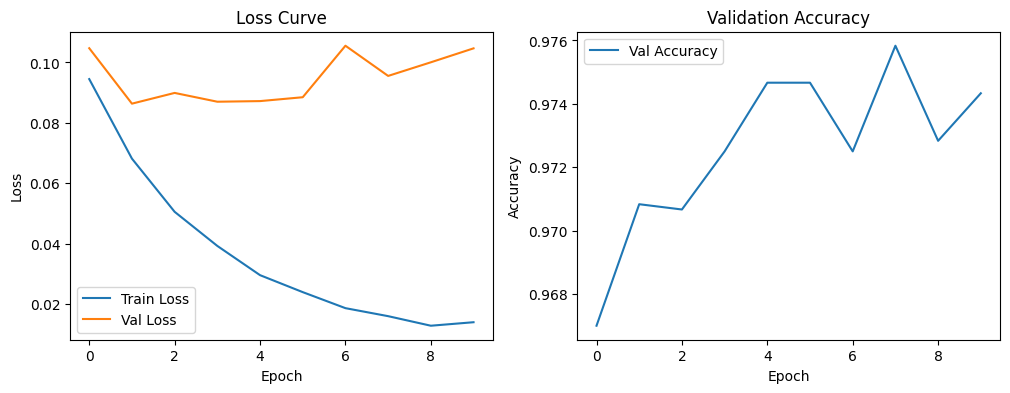

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()
